# tabletop calibration

Make sure that the simulation is running:

```bash
roslaunch handy_warehouse_demo tabletop.launch
```

And with this we can do a bit of analysis on the images. We've changed the color of the table's material to make it easy to mask against other objects.

- https://stanford.edu/class/ee367/Winter2015/report_loewke.pdf
- https://pvela.gatech.edu/classes/doku.php?id=ece4580:schedule
- https://pvela.gatech.edu/classes/lib/exe/fetch.php?media=ece4580:ece4580_t03_calibration.pdf


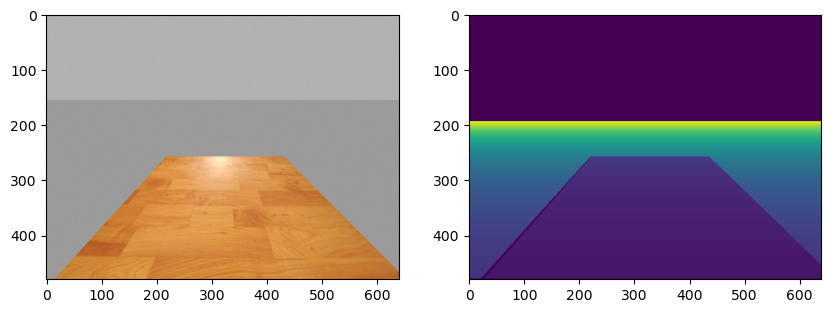

In [1]:
import matplotlib.pyplot as plt
import rospy
from cv_bridge import CvBridge
from sensor_msgs.msg import Image

rospy.init_node("realsense_subscriber")
bridge = CvBridge()

msg = rospy.wait_for_message("/camera/color/image_raw", Image)
rgb = bridge.imgmsg_to_cv2(msg, msg.encoding)

msg = rospy.wait_for_message("/camera/aligned_depth_to_color/image_raw", Image)
depth = bridge.imgmsg_to_cv2(msg, msg.encoding)

# show subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(rgb)
ax[1].imshow(depth)
plt.show()

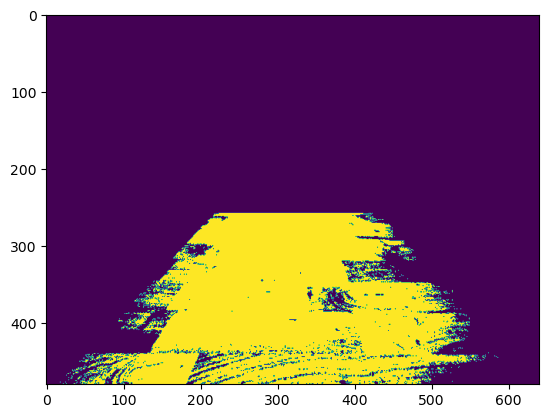

In [2]:
red = rgb[:, :, 0]
red_mask = (red - red.mean())/red.std() > 1
plt.imshow(red_mask)
plt.show()

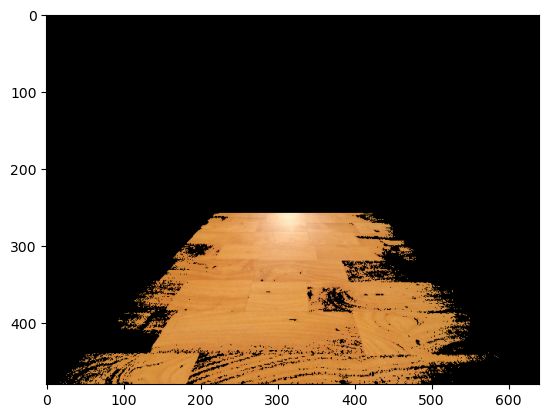

In [3]:
X = rgb.copy()
X[~red_mask] = 0
plt.imshow(X)

## moving camera

Maybe it's a good idea to move the camera, to simplify the problem. I am having a prety hard time adjusting the position of the camera correctly via the orientation. The simulated ros camera driver here is not great. 

In [4]:
! rostopic list | grep gazebo

/gazebo/link_states
/gazebo/model_states
/gazebo/parameter_descriptions
/gazebo/parameter_updates
/gazebo/performance_metrics
/gazebo/set_link_state
/gazebo/set_model_state


In [53]:
! rosservice call /gazebo/get_model_state "model_name: camera"

header: 
  seq: 1
  stamp: 
    secs: 423
    nsecs: 115000000
  frame_id: ''
pose: 
  position: 
    x: -2.0
    y: 0.0
    z: 0.9999999999999999
  orientation: 
    x: 0.0
    y: 0.19509032201612825
    z: 0.0
    w: 0.9807852804032304
twist: 
  linear: 
    x: 0.0
    y: 0.0
    z: 0.0
  angular: 
    x: 0.0
    y: 0.0
    z: 0.0
success: True
status_message: "GetModelState: got properties"


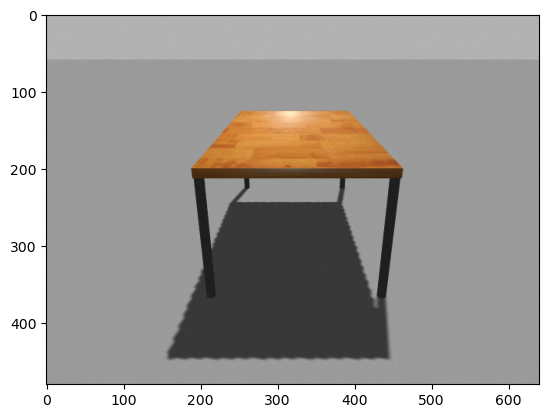

In [54]:
from gazebo_msgs.msg import ModelState
from gazebo_msgs.srv import GetModelState, SetModelState
import numpy as np

# https://automaticaddison.com/how-to-convert-euler-angles-to-quaternions-using-python/
def get_quaternion_from_euler(roll, pitch, yaw):
  """
  Convert an Euler angle to a quaternion.
   
  Input
    :param roll: The roll (rotation around x-axis) angle in radians.
    :param pitch: The pitch (rotation around y-axis) angle in radians.
    :param yaw: The yaw (rotation around z-axis) angle in radians.
 
  Output
    :return qx, qy, qz, qw: The orientation in quaternion [x,y,z,w] format
  """
  qx = np.sin(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) - np.cos(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
  qy = np.cos(roll/2) * np.sin(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.cos(pitch/2) * np.sin(yaw/2)
  qz = np.cos(roll/2) * np.cos(pitch/2) * np.sin(yaw/2) - np.sin(roll/2) * np.sin(pitch/2) * np.cos(yaw/2)
  qw = np.cos(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
  return [qx, qy, qz, qw]


def move_camera_pos(x, y, z, pitch=0, name="camera"):
    rospy.wait_for_service("/gazebo/set_model_state")
    set_state = rospy.ServiceProxy("/gazebo/set_model_state", SetModelState)
    msg = ModelState()
    msg.model_name = name
    msg.pose.position.x = x
    msg.pose.position.y = y
    msg.pose.position.z = z
    # convert pitch to quaternion
    qx, qy, qz, qw = get_quaternion_from_euler(0, pitch, 0)
    msg.pose.orientation.x = qx
    msg.pose.orientation.y = qy
    msg.pose.orientation.z = qz
    msg.pose.orientation.w = qw
    set_state(msg)

move_camera_pos(-2, 0, 1, pitch=np.pi/8)
msg = rospy.wait_for_message("/camera/color/image_raw", Image)
rgb = bridge.imgmsg_to_cv2(msg, msg.encoding)
plt.imshow(rgb)


# appendix

## point clouds

We have difficulty converting between the color image and the depth map, because they do not map cleanly. See documentation on the [realsense wiki](https://github.com/IntelRealSense/librealsense/wiki/Projection-in-RealSense-SDK-2.0).

In [14]:
! rostopic type /camera/depth/color/points 
! rostopic echo /camera/depth/color/points | head -n30

sensor_msgs/PointCloud2
header: 
  seq: 2008
  stamp: 
    secs: 158
    nsecs: 993000000
  frame_id: "camera_depth_optical_frame"
height: 720
width: 1280
fields: 
  - 
    name: "x"
    offset: 0
    datatype: 7
    count: 1
  - 
    name: "y"
    offset: 4
    datatype: 7
    count: 1
  - 
    name: "z"
    offset: 8
    datatype: 7
    count: 1
  - 
    name: "rgb"
    offset: 16
    datatype: 7
    count: 1
is_bigendian: False


In [6]:
from sensor_msgs.msg import PointCloud2
import ros_numpy
import numpy as np

def convert_pointcloud(data):
    pc = ros_numpy.numpify(data)
    points=np.zeros((*pc.shape, 4))
    points[:,:,0]=pc['x']
    points[:,:,1]=pc['y']
    points[:,:,2]=pc['z']
    points[:,:,3]=pc['rgb']
    return np.array(points, dtype=np.float32)

msg = rospy.wait_for_message("/camera/depth/color/points", PointCloud2, timeout=5)
X = convert_pointcloud(msg)
X.shape

# create a 2x2 grid of subplots and plot point cloud data
fig, ax = plt.subplots(2, 2)
labels = ['x', 'y', 'z', 'rgb']
axes = ax.ravel()
for i in range(4):
    axes[i].set_title(labels[i])
    axes[i].imshow(X[:, :, i])
plt.tight_layout()
plt.show()

(720, 1280, 4)

## clustering

/home/anthony/.local/lib/python3.10/site-packages/scipy/cluster/vq.py:603: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


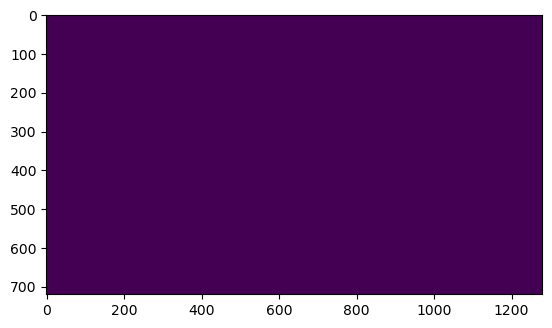

In [57]:
from scipy.cluster.vq import kmeans2, whiten
import numpy as np

# compute kmeans from depth

shape = depth.shape
X = whiten(depth.reshape(-1, 1))
_, label = kmeans2(X, 2)
label_img = label.reshape(shape)
plt.imshow(label_img)
plt.show()

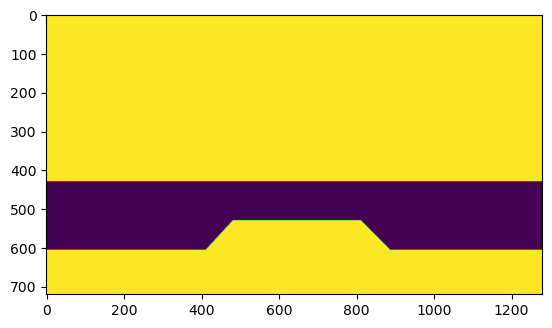

In [58]:
import cv2 as cv

gray = (depth/depth.max()*255).astype(np.uint8)
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
plt.imshow(thresh)